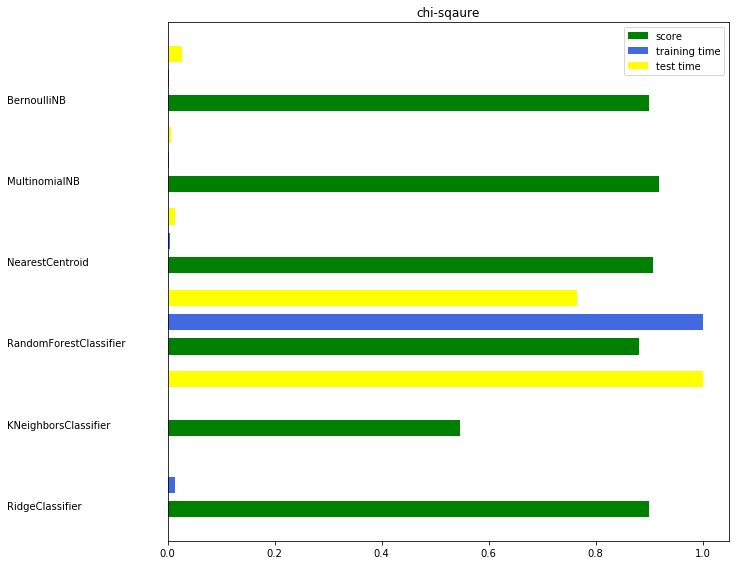

In [7]:
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


categories = ['talk.religion.misc',
        
        'sci.space'
    ]


remove = ('headers', 'footers', 'quotes')

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

categories = data_train.target_names    # for case categories == None


# split a training set and a test set
y_train, y_test = data_train.target, data_test.target


t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)

t0 = time()
X_test = vectorizer.transform(data_test.data)

feature_names = vectorizer.get_feature_names()

t0 = time()
ch2 = SelectKBest(chi2, k='all')
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)
feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
feature_names = np.asarray(feature_names)

###############################################################################
# Benchmark classifiers
def benchmark(clf):
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    score = metrics.accuracy_score(y_test, pred)
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
       
        
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    results.append(benchmark(clf))

# Train SGD with Elastic Net penalty
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("chi-sqaure")
plt.barh(indices, score, .2, label="score", color='green')
plt.barh(indices + .3, training_time, .2, label="training time", color='royalblue')
plt.barh(indices + .6, test_time, .2, label="test time", color='yellow')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()